In [2]:
import os
import h5py
import numpy as np
import pandas as pd
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [1]:
%cd ..

/raid/homes/nicola.messina/workspace/papyri/papyrus-matching


/raid/homes/nicola.messina/anaconda3/envs/papyri/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
def process_hdf5_file(filepath):
    """
    Reads a single HDF5 file, calculates the max mean translation score,
    and returns the fragment names and the score.
    """
    try:
        with h5py.File(filepath, 'r') as f:
            # Check if datasets exist
            if 'scores' not in f or 'translation_ids' not in f:
                print(f"Warning: Skipping {filepath} (missing datasets)")
                return None, None, None

            scores = f['scores'][:]
            translation_ids = f['translation_ids'][:]
            
            # Get fragment names from attributes
            # Use Path().stem to get clean names like "test_fragment_easy1_L"
            name_a = Path(f.attrs['fragment_a']).stem
            name_b = Path(f.attrs['fragment_b']).stem
            
            if scores.size == 0 or translation_ids.size == 0:
                print(f"Warning: Skipping {filepath} (empty datasets)")
                return name_a, name_b, 0.0 # Return 0 score

            # Use pandas to group by translation_id and get the mean
            df = pd.DataFrame({
                'score': scores,
                'translation_id': translation_ids
            })
            
            # This replicates your original "pooled_score" logic
            mean_scores_per_translation = df.groupby('translation_id')['score'].mean()
            
            # Find the max score among all possible translations
            max_score = mean_scores_per_translation.max()
            
            return name_a, name_b, max_score

    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None, None, None

def create_score_matrix(hdf5_dir):
    """
    Reads all HDF5 files in a directory and assembles them into a
    score matrix.
    """
    file_paths = glob.glob(os.path.join(hdf5_dir, "*.hdf5"))
    if not file_paths:
        print(f"Error: No .hdf5 files found in {hdf5_dir}")
        return
        
    score_data = []
    fragment_names = set()

    print(f"Found {len(file_paths)} score files. Processing...")
    for path in tqdm(file_paths, desc="Reading score files"):
        name_a, name_b, score = process_hdf5_file(path)
        
        if name_a and name_b:
            score_data.append((name_a, name_b, score))
            fragment_names.add(name_a)
            fragment_names.add(name_b)
            
    if not score_data:
        print("No valid score data could be read.")
        return

    # Create the matrix
    sorted_names = sorted(list(fragment_names))
    name_to_idx = {name: i for i, name in enumerate(sorted_names)}
    matrix_size = len(sorted_names)
    score_matrix = np.full((matrix_size, matrix_size), np.nan)
    
    # Populate the matrix
    for name_a, name_b, score in score_data:
        idx_a = name_to_idx.get(name_a)
        idx_b = name_to_idx.get(name_b)
        
        if idx_a is not None and idx_b is not None:
            score_matrix[idx_a, idx_b] = score
            score_matrix[idx_b, idx_a] = score # Make it symmetric
    
    # Fill diagonal with 1.0 (perfect self-match)
    np.fill_diagonal(score_matrix, 1.0)
    
    # Plot the heatmap
    print("Plotting heatmap...")
    # Adjust figsize dynamically
    fig_width = max(10, matrix_size * 0.8)
    fig_height = max(8, matrix_size * 0.7)
    
    plt.figure(figsize=(fig_width, fig_height))
    
    # Use a "hot" colormap where higher is brighter
    cmap = sns.color_palette("flare", as_cmap=True)
    
    sns.heatmap(
        score_matrix,
        xticklabels=sorted_names,
        yticklabels=sorted_names,
        annot=True,          # Show the score values
        fmt=".3f",           # Format to 3 decimal places
        cmap=cmap,
        linewidths=.5,
        cbar_kws={'label': 'Max Mean Translation Score'}
    )
    
    plt.title("Fragment Alignment Score Matrix", fontsize=16)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save and show
    output_filename = "fragment_score_matrix.png"
    plt.savefig(output_filename)
    print(f"Heatmap saved to {output_filename}")
    plt.show()

Found 21 score files. Processing...


Reading score files: 100%|██████████| 21/21 [00:00<00:00, 553.18it/s]

Plotting heatmap...


Heatmap saved to fragment_score_matrix.png


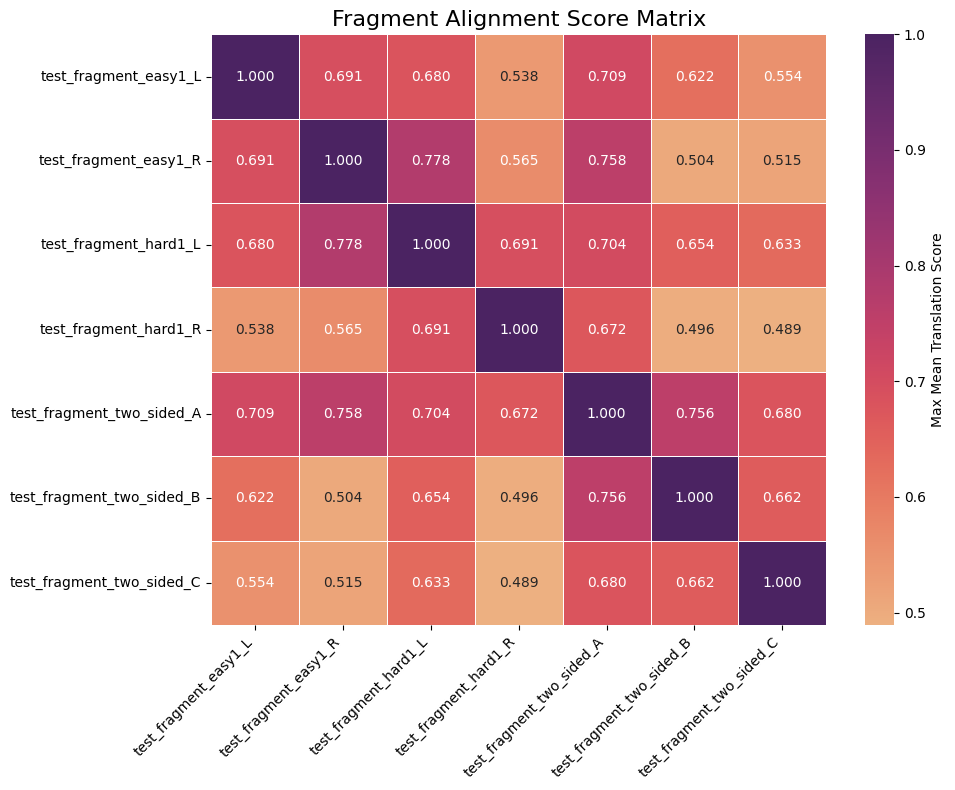

In [6]:
# --- CONFIGURATION ---
# Directory where your .hdf5 files are saved
HDF5_DIR = "results/fragment_scores"
# ---------------------

create_score_matrix(HDF5_DIR)